# Stock Assets Analyser

This notebook will implement the stockutils module to analyse user stock transaction history.

In [1]:
from stockutils import readers as sur
from stockutils import parsers as sup
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=20,10

In [2]:
# General settings

testMode = False
marketdatadir = 'market-data'
userdatadir = 'user-data'

In [3]:
def underSampleSeries(xdata, ydata, factor):
    """
    Reduces the number of x and y samples by the given factor.
    
    Parameters
    ----------
    xdata: list
        list of labels. No algebraic operation will be done on this data, 
        only 'factor-1' for every 'factor' points will be dropped.
    
    ydata: list 
        list of values (int or float), every 'factor' samples will be 
        combined into one.
    
    Raises
    ----------
    ValueError
        If lengths of xdata and ydata differ.
    
    Return
    ----------
    newxdata: list
        List of new x data.
        
    newydata: list
        List of new y data.
    """
    if len(xdata) != len(ydata):
        raise ValueError('length of xdata and ydata should match')
    
    newxdata = []
    newydata = []
    
    for c in range(0, int(len(xdata)/factor)):
        # new xdata point should the middle point of each factor length block
        newxdata.append(xdata[factor*c + int(factor/2)])
        
        # new ydata will be the average of 'factor' samples
        newysample = 0
        for i in range(0, factor):
            newysample += ydata[c*factor + i]
        newysample /= factor
        
        newydata.append(newysample)
        
    return newxdata, newydata

In [4]:
def plotTwoCurves(dateRange, setA, setALabel, setB, setBLabel, undersamplefactor=1):
    
    newdateRange, newsetA = underSampleSeries(dateRange, setA, undersamplefactor)
    _, newsetB = underSampleSeries(dateRange, setB, undersamplefactor)
    
    fig, ax1 = plt.subplots()

    # Stock value
    color = 'tab:red'
    ax1.set_xlabel('date')
    ax1.set_ylabel(setALabel, color=color)
    ax1.plot(newdateRange, newsetA, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # IBOV index
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel(setBLabel, color=color)
    ax2.plot(newdateRange, newsetB, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=90)
    plt.show()

In [5]:
# read transactions: dict(key:str(day)) of list of Transaction

ui = sur.UserDataImporter(inputdir=userdatadir, testMode=testMode)
transactions = ui.getUserInputData()

In [6]:
# get assets: list of assets ticker in str format
assets = []

for key in transactions.keys():
    ts = transactions[key]
    for t in ts:
        if t.ticker not in assets:
            assets.append(t.ticker)

In [7]:
# read ibovData: dict(key:str(day)) of IBOVDayData

ihi = sur.IBOVHistoryImporter(inputdir=marketdatadir, testMode=testMode)
ibovData = ihi.readAndParseIBOVInputFile()

In [8]:
# read days: list of str (YYYYMMDD format)
days = [str(d) for d in ibovData.keys()]
days.sort()

In [9]:
# read stockPrice: dict(key:str(ticker)) of dict(key:str(day)) of float(price)
stockPrice = {}

b3h = sur.B3HistoryImporter(inputdir=marketdatadir, assets=assets, testMode=testMode)
b3h.readAndParseRawInputFile()

for asset in assets:
    stockPrice[asset] = b3h.getTickerData(asset)

In [10]:
#compute assetDayQuantity: list of AssetQuantityRange
assetDayQuantity = sup.calculateDailyAssetQuantity(days, assets, transactions)

In [11]:
#compute dailyportifoliovalue: dict(key:str(day)) of float(total value of portifolio)
dailyportifoliovalue = sup.calculateDailyPortifolioValue(days, stockPrice, assetDayQuantity, stockPrice)

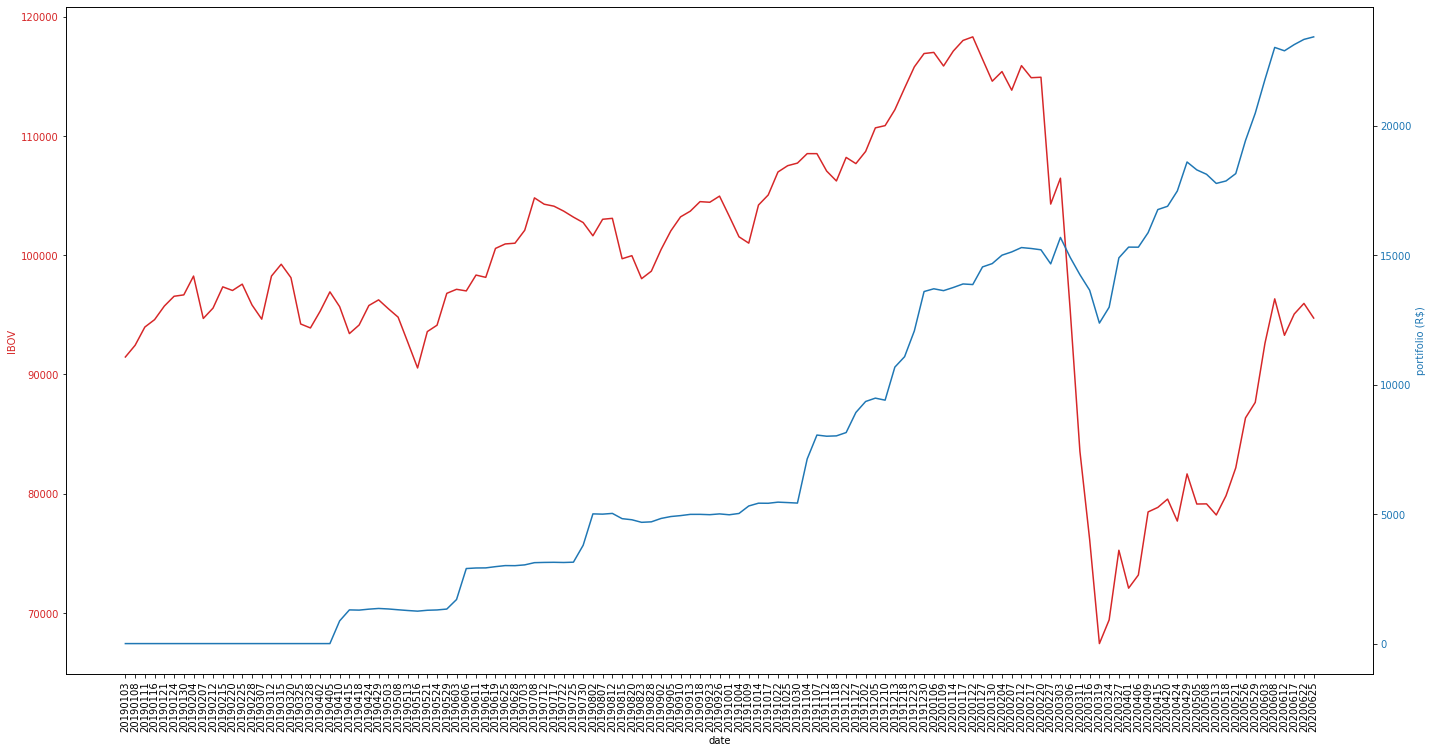

In [12]:
# get IBOV and total portifolio values over time

ibovPoints = []
portValuePoints = []

for day in days:
    ibovPoints.append(ibovData[day].closing)
    portValuePoints.append(dailyportifoliovalue[day])

plotTwoCurves(days, ibovPoints, 'IBOV', portValuePoints, 'portifolio (R$)', undersamplefactor=3)

In [13]:
totalinputmoney = 0
for d in transactions.keys():
    for t in transactions[d]:
        totalinputmoney += (t.buyQtty * t.buyPrice - t.sellQtty * t.sellPrice)
totalinputmoney

23733.79

In [15]:
newportval = sup.differentTickerBuySim(days, assets, stockPrice, transactions, "20191127", "CVCB3", "MDIA3")

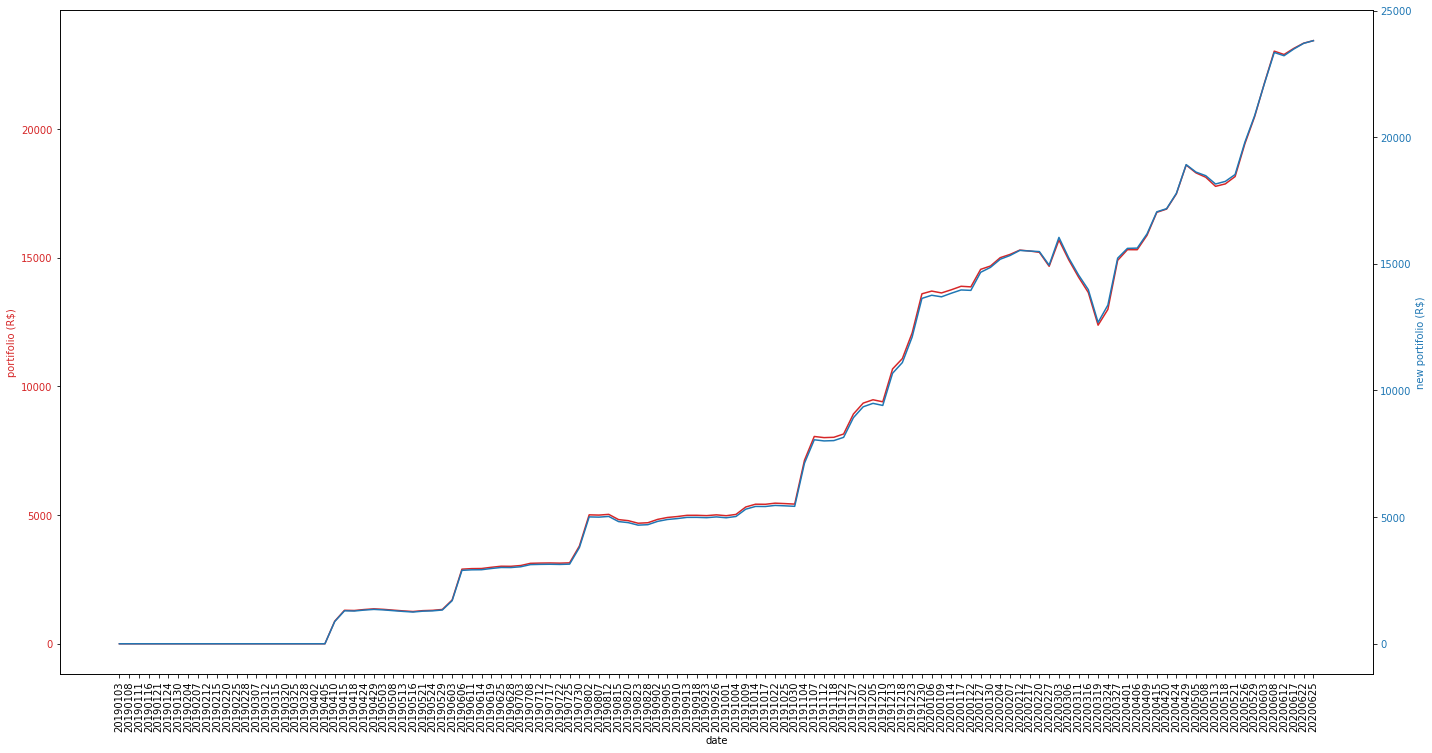

In [16]:
newportvalpoints = []

for day in days:
    newportvalpoints.append(newportval[day])
    
plotTwoCurves(days, portValuePoints, 'portifolio (R$)', newportvalpoints, 'new portifolio (R$)', undersamplefactor=3)

In [17]:
portValuePoints[-1]

24123.08

In [18]:
newportvalpoints[-1]

24505.764571776897